# Clustering RGB image features with PhenoGraph

#### This notebook uses the matrix of 672 features per single cell RGB cropped image to cluster the cells and identify which are red blood cells based on clustering pattern

## Importing

In [1]:
import warnings
# To ignore Pandas Future Warning
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
print("phenograph==", phenograph.__version__)
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.1 pynndescent==0.5.7
phenograph== 1.5.7


In [3]:
from os import listdir
from os.path import isfile, join

### Read in feature matrix as csv

In [4]:
pt = 'P58'

In [5]:
# read in features from each fov
feats_dir = 'Normalized_RGB_feats/'
tables = [f for f in listdir(feats_dir) if isfile(join(feats_dir, f))]
tables.sort()

In [6]:
# create all-fov feats table
all_fovs = pd.read_csv(feats_dir + tables[0], index_col=0)

for i in range(1,len(tables)):
    data = pd.read_csv(feats_dir + tables[i], index_col=0)
    all_fovs = pd.concat([all_fovs, data])
    
all_fovs

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
P58_FOV01_cell_1,0.501527,2.167525,3.137715,2.576609,0.637159,0.538885,2.306502,-0.158581,0.973179,0.405821,...,0.656329,0.189158,0.266561,-0.001978,1.745170,0.220969,3.486932,0.525812,0.600983,-0.090550
P58_FOV01_cell_2,0.459329,2.331693,3.131803,2.527337,0.749816,0.556156,2.261336,-0.151408,0.884559,0.431228,...,0.521267,0.064968,0.222082,0.032749,1.769198,0.190889,3.455953,0.175879,0.649756,-0.068559
P58_FOV01_cell_3,0.443164,2.394093,3.117167,2.511101,0.598767,0.514874,2.267470,-0.074919,1.006935,0.508245,...,0.514551,0.070816,0.358349,0.027053,1.775186,0.221803,3.394718,0.196799,0.585591,-0.058399
P58_FOV01_cell_4,0.426721,2.458324,3.133213,2.265525,0.955588,0.553396,2.172890,-0.142909,1.141727,0.693742,...,0.542641,0.144437,0.475662,0.090120,1.840020,0.278873,3.421516,0.096935,0.443725,-0.036024
P58_FOV01_cell_5,0.418717,2.457060,3.032480,2.425812,0.731853,0.549040,2.237158,-0.107201,1.143872,0.571794,...,0.523329,0.174067,0.780755,0.054138,1.815886,0.288519,3.408058,0.050086,0.543861,-0.040398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P58_FOV23_cell_7971,0.420015,2.500317,3.136168,2.585814,0.907871,0.432079,2.315032,-0.155753,0.878577,0.315941,...,0.532210,-0.033017,0.160269,0.010305,1.760109,0.185342,3.477719,0.134681,0.564227,-0.058207
P58_FOV23_cell_7972,0.399459,2.568809,3.121929,2.585184,0.630299,0.465419,2.329074,-0.154224,0.808695,0.299707,...,0.484801,-0.039468,0.198132,0.000089,1.779866,0.151070,3.446518,0.001038,0.582719,-0.050769
P58_FOV23_cell_7973,0.408148,2.509319,3.149809,2.586563,0.573308,0.414924,2.354183,-0.162015,0.777947,0.290430,...,0.503332,-0.029243,0.172950,-0.011243,1.771452,0.152130,3.448875,0.026938,0.578152,-0.054960
P58_FOV23_cell_7974,0.391695,2.655602,3.116905,2.607563,0.548437,0.506525,2.351344,-0.138566,0.814074,0.318592,...,0.506128,-0.036634,0.161389,-0.005383,1.806264,0.175374,3.435069,-0.013785,0.536866,0.006486


In [7]:
# concatenate individual FOV feature tables as 1 large feature table
all_fovs.to_csv(pt + "_all_cell_RGB_features.csv", header=False)

In [8]:
# read in feature matrix as anndata object for clustering
adata = sc.read_csv(pt + "_all_cell_RGB_features.csv", first_column_names=True)
adata

AnnData object with n_obs × n_vars = 131339 × 672

In [9]:
adata.obs

""
P58_FOV01_cell_1
P58_FOV01_cell_2
P58_FOV01_cell_3
P58_FOV01_cell_4
P58_FOV01_cell_5
...
P58_FOV23_cell_7971
P58_FOV23_cell_7972
P58_FOV23_cell_7973
P58_FOV23_cell_7974


In [10]:
# load FOV metadata
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata

,Timepoint,Clinical outcome
P51_FOV01,A,PD
P51_FOV02,A,PD
P51_FOV03,A,PD
P51_FOV04,A,PD
P51_FOV05,A,PD
...,...,...
P58_FOV19,C,SD
P58_FOV20,C,SD
P58_FOV21,C,SD
P58_FOV22,C,SD


In [11]:
# get FOV and cell number from cell ID

adata.obs['FOV'] = ''
adata.obs['cell_ID'] = 0
adata.obs['Timepoint'] = ''

for i in range(adata.obs.shape[0]):
    adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
    adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')
    adata.obs['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[adata.obs.iloc[i].name[0:9]]

adata.obs

/tmp/ipykernel_3715024/2228281499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['FOV'].iloc[i] = adata.obs.iloc[i].name[7:9]
/tmp/ipykernel_3715024/2228281499.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['cell_ID'].iloc[i] = adata.obs.iloc[i].name[15:].replace('.png', '')


,FOV,cell_ID,Timepoint
P58_FOV01_cell_1,01,1,A
P58_FOV01_cell_2,01,2,A
P58_FOV01_cell_3,01,3,A
P58_FOV01_cell_4,01,4,A
P58_FOV01_cell_5,01,5,A
...,...,...,...
P58_FOV23_cell_7971,23,7971,C
P58_FOV23_cell_7972,23,7972,C
P58_FOV23_cell_7973,23,7973,C
P58_FOV23_cell_7974,23,7974,C


In [12]:
# save copy of complete anndata object
adata_all = adata

## Cluster Timepoint A FOVs for RBCs

In [13]:
tp = 'A'

In [14]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 50821 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [15]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [16]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

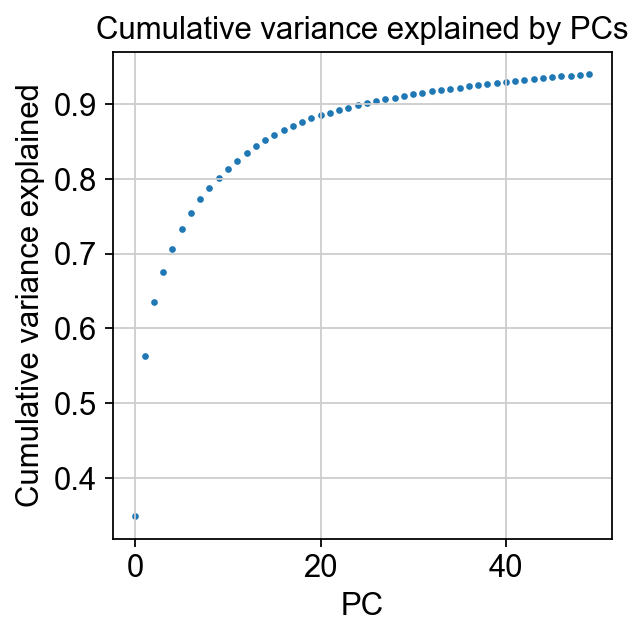

In [17]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [18]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [19]:
k = 15 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 55.892335176467896 seconds
Jaccard graph constructed in 8.23817229270935 seconds
Wrote graph to binary file in 0.23108363151550293 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.752354
After 2 runs, maximum modularity is Q = 0.754544
After 9 runs, maximum modularity is Q = 0.756785
Louvain completed 29 runs in 16.75570583343506 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 83.82867646217346 seconds


In [20]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


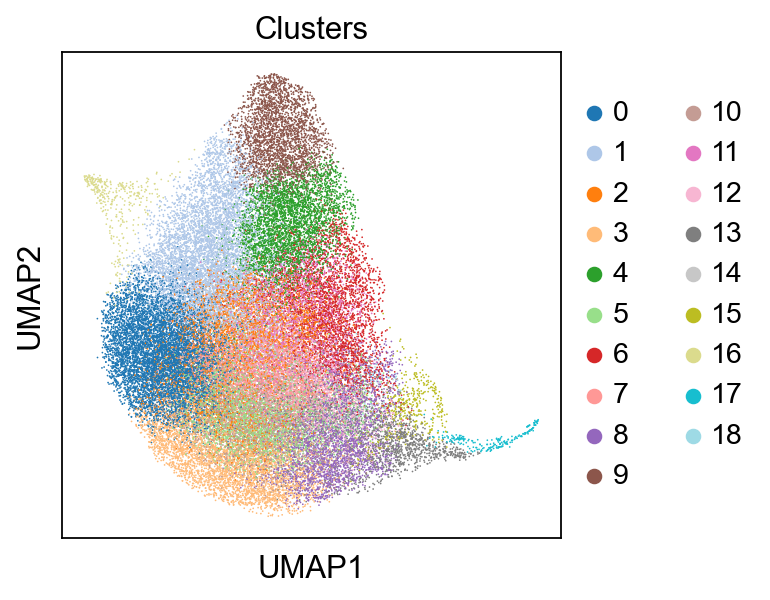

In [21]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


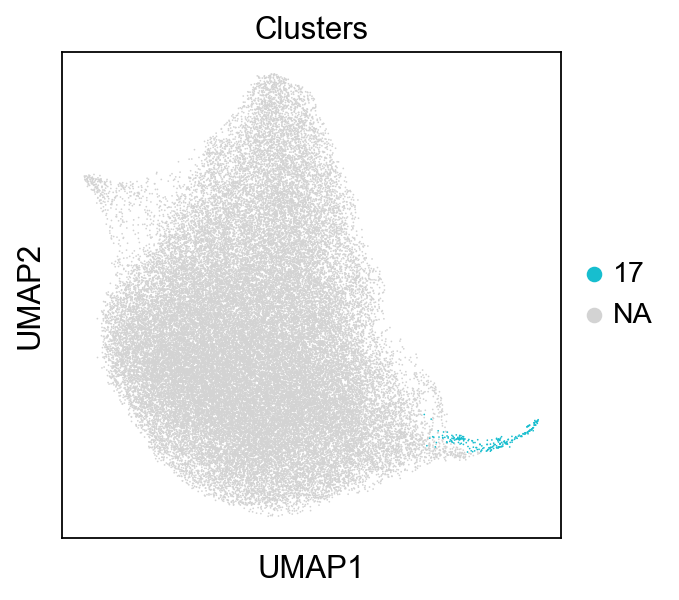

In [26]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[17]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


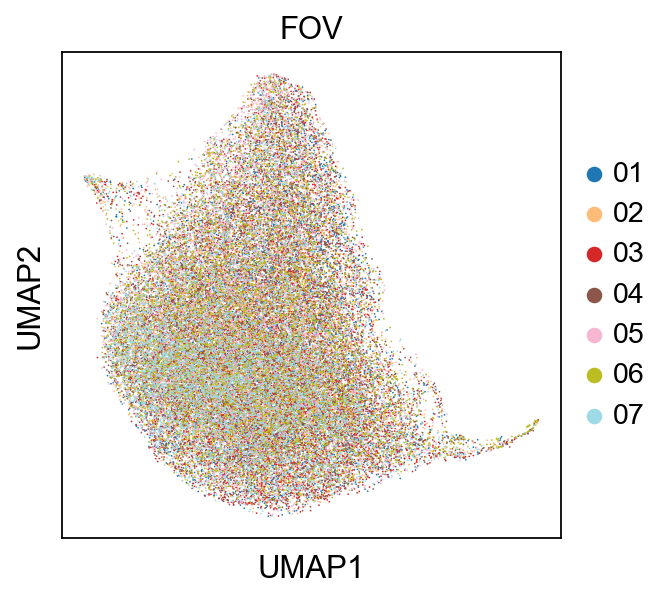

In [23]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [24]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [25]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint B FOVs for RBCs

In [43]:
tp = 'B'

In [44]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 33200 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [45]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [46]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

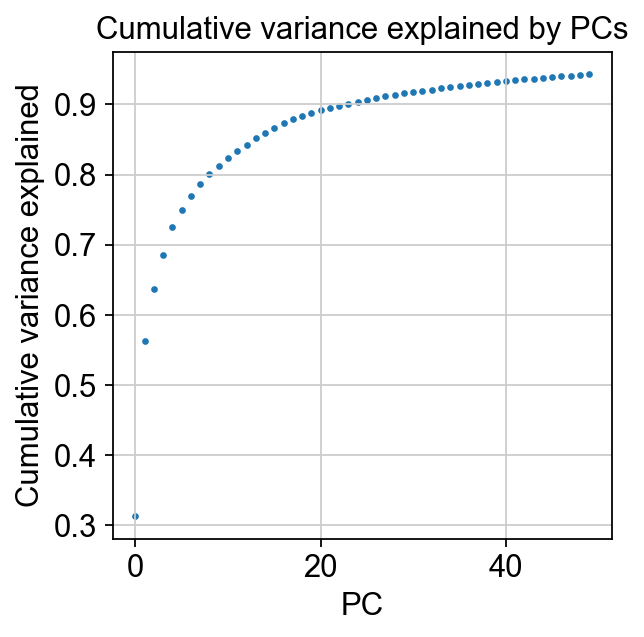

In [47]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [48]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [49]:
k = 10 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 23.702508211135864 seconds
Jaccard graph constructed in 6.196064710617065 seconds
Wrote graph to binary file in 0.09320592880249023 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.80892
After 2 runs, maximum modularity is Q = 0.811681
Louvain completed 22 runs in 5.360354423522949 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 38.46558690071106 seconds


In [50]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [51]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


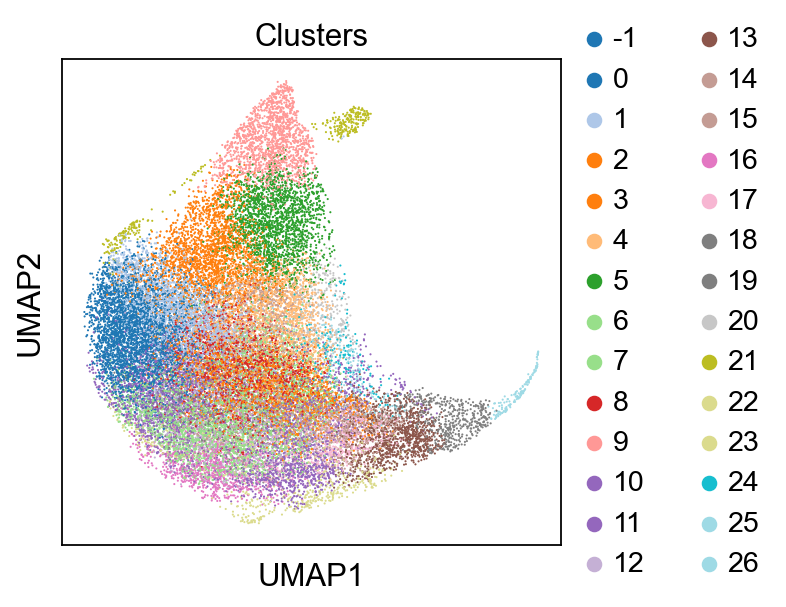

In [52]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


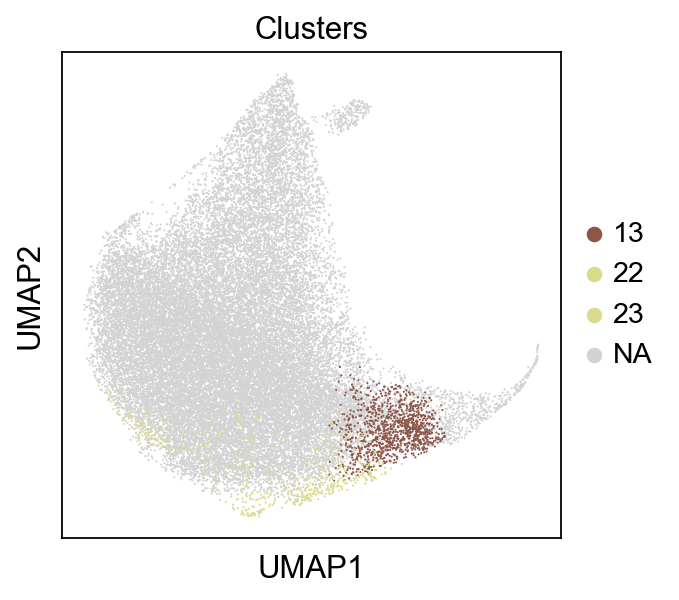

In [64]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[13,22,23]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


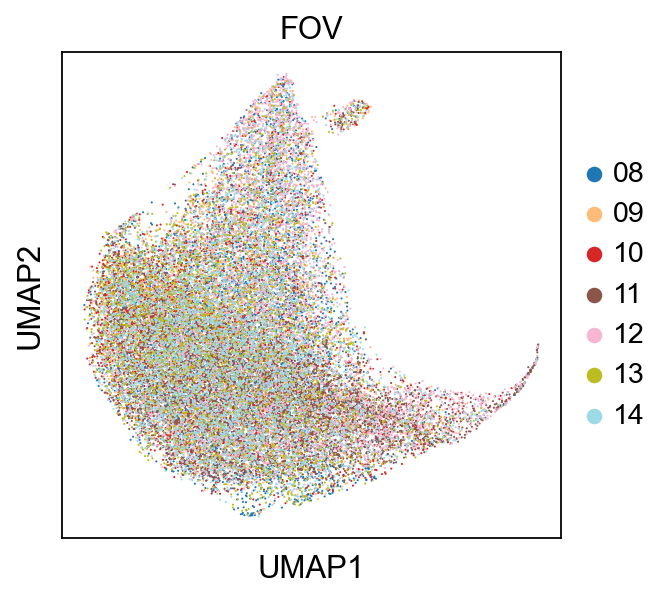

In [65]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [66]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [67]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')

## Cluster Timepoint C FOVs for RBCs

In [68]:
tp = 'C'

In [69]:
# subset adata to just TPA
adata = adata_all[adata_all.obs['Timepoint'] == tp]
adata

View of AnnData object with n_obs × n_vars = 47318 × 672
    obs: 'FOV', 'cell_ID', 'Timepoint'

## Pre-Processing

### Log-Transformation

In [70]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata, copy = True)

### Principal Component Analysis (PCA)

In [71]:
#adata = adata_log1p # don't use log-scaled dataset
adata = sc.tl.pca(adata, n_comps = 50, copy = True)

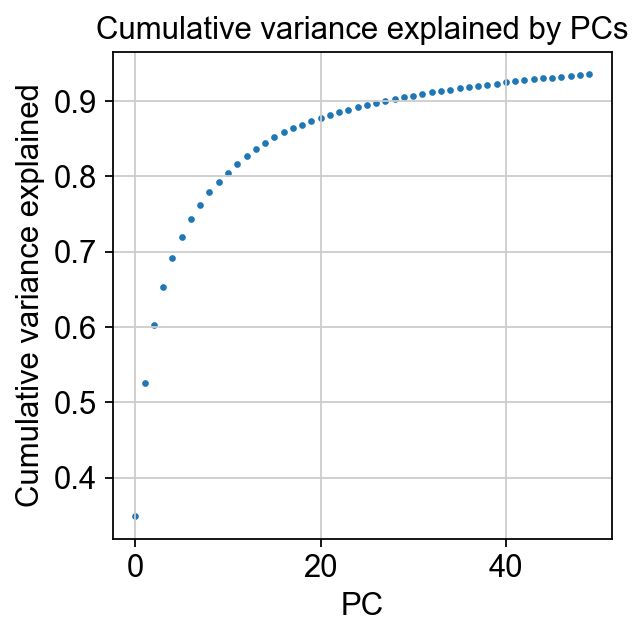

In [72]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [73]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 0


## Clustering with PhenoGraph

### Running PhenoGraph

In [74]:
k = 10 # choose k, smaller values for finer-grained clustering
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 50.622129678726196 seconds
Jaccard graph constructed in 6.36740779876709 seconds
Wrote graph to binary file in 0.13466668128967285 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.803083
After 18 runs, maximum modularity is Q = 0.805326
Louvain completed 38 runs in 13.057361841201782 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 72.85804867744446 seconds


In [75]:
# run clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)

In [76]:
# read in clustered df
#adata = sc.read_h5ad("P56" + tp + "_RGB_cell_features_clustered.h5ad")
#adata

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


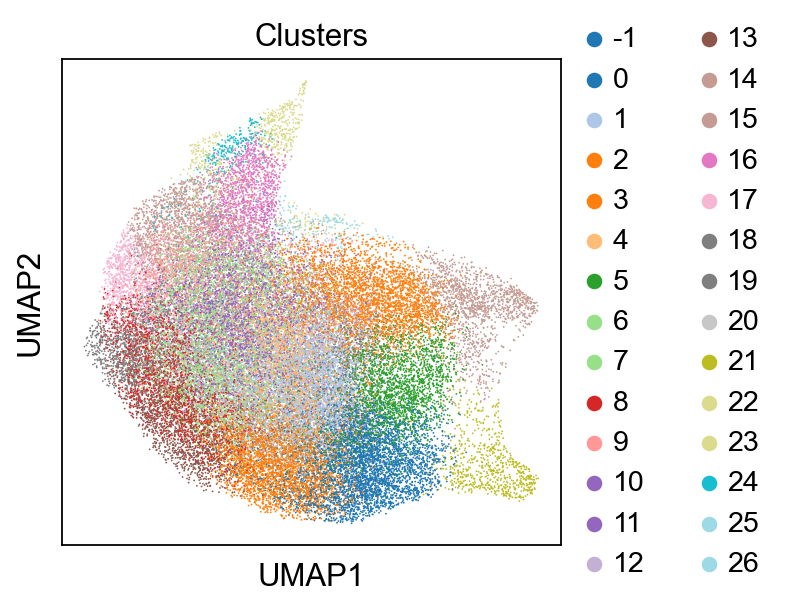

In [77]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


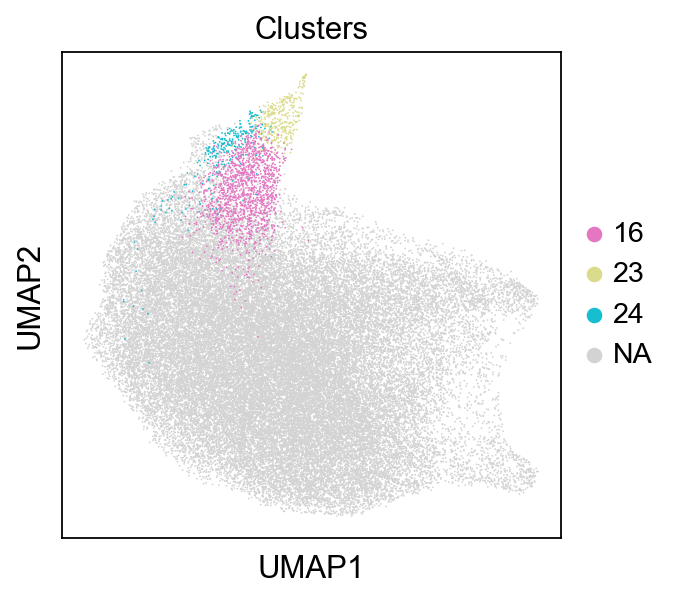

In [85]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20',
    title=["Clusters"], groups=[16,23,24]
)

/home/annemb/.conda/envs/phenograph-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


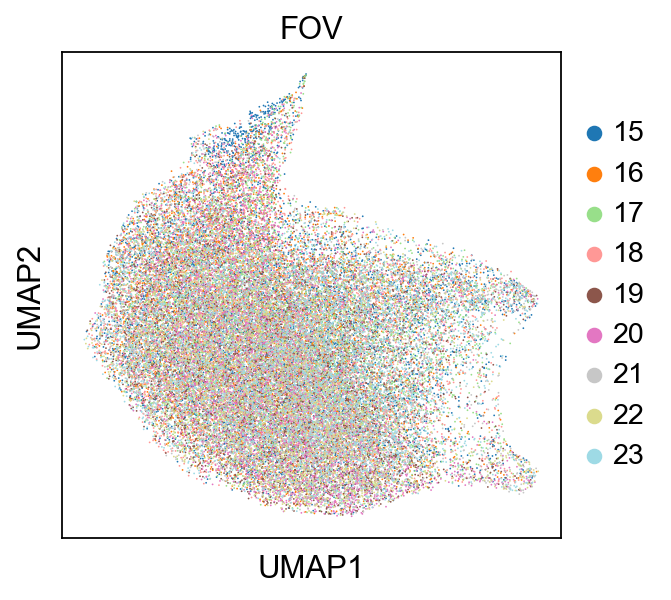

In [80]:
sc.pl.umap(
    adata, 
    color=['FOV'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["FOV"]
)

In [81]:
# save dataframe of clustering results (adata.obs)
adata.obs.to_csv('TP' + tp + '/' + pt + tp + '_RGB_clusters.csv')

In [82]:
# save clustered data anndata object
adata_all.write_h5ad('TP' + tp + '/' + pt + tp + '_RGB_cell_features_clustered.h5ad')